In [1]:

from settings import MOTIONS_FILE_PATH, MOTIONS_FILE_PATH_LOCK, MOTIONS_FOLDER
import json
import pandas as pd
from Tracker.Motion import Motion
import os

with MOTIONS_FILE_PATH_LOCK:
    with open(MOTIONS_FILE_PATH, "r") as f:
        motions_header = json.load(f)


labeled_motions: dict = {

}

for motion_header in motions_header["stored_motions"]:
    new_motion = Motion.from_file(os.path.join(
        MOTIONS_FOLDER, motion_header["id"]))
    if new_motion is None:
        print("Failed to open motion")
        exit(0)
    
    labeled_motions[motion_header["label"]] = labeled_motions.get(motion_header["label"], [])

    for shape in motion_header["shapes_acce"]:
        streams = new_motion.as_linear()
        labeled_motions[motion_header["label"]].append(
            [stream[shape["start"]:shape["end"]] for stream in streams])

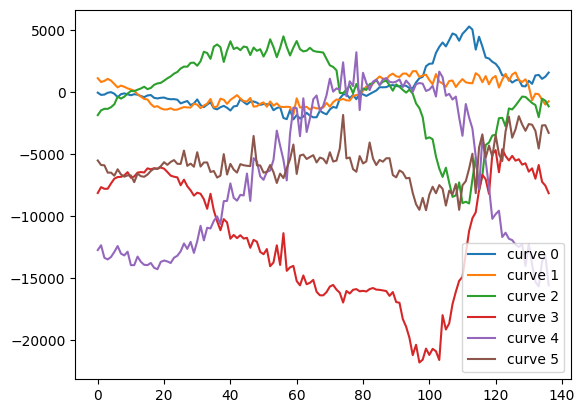

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
for streams in labeled_motions["bicep-curl-right"]:
    for i,stream in enumerate( streams):
        plt.plot(stream, label = f"curve {i}") 
    plt.legend() 
    plt.show()
    break

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import os
from matplotlib import rc, rcParams, colors, animation


def set_fig_style(fig, font_size=22, bg_color_html="#f9fafb"):
    if bg_color_html is not None:
        blog_color = (249/255, 250/255, 251/255, 255/255)
        fig.patch.set_facecolor(blog_color)
        for ax in fig.axes:
            ax.set_facecolor(blog_color)
    rcParams.update({
        'text.latex.preamble': r'\usepackage{newtxmath}',
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "New Century Schoolbook", "Bookman", "Computer Modern Roman"],
        "font.size": font_size
    })
    rc('text', usetex=True)


def export_animation(anim, fname, ext=None, fps=5, dpi=200):
    if ext is None:
        # If ext is None, all GIF+video figures are generated
        for ext in ["gif", "mp4", "webm"]:
            export_animation(anim, fname, ext=ext)
    fname_with_ext = f"{fname}.{ext}"
    if ext == "gif":
        anim.save(fname_with_ext, dpi=dpi, savefig_kwargs={'pad_inches': 'tight'})
    elif ext == "html":
        rcParams["animation.frame_format"] = "svg"
        html_widget = anim.to_jshtml(default_mode="loop")
        open(fname_with_ext, "w").write(html_widget)  # Generated files are huge...
    elif ext in ["mp4", "webm"]:
        Writer = animation.writers['ffmpeg']
        if ext == "mp4":
            writer = Writer(fps=fps, codec="libx265")
        else:
            writer = Writer(fps=fps, codec='libvpx-vp9')
        anim.save(fname_with_ext, writer=writer, dpi=dpi)
    else:
        print(f"Unrecognized extension: {ext}")

shift = 15
length = 60


np.random.seed(0)
def plot_animation(X_train,path):
    def animate(i):
        for j in range(len(X_train)):
            if j < i:
                lines[j].set_alpha(lines[j].get_alpha() * .7)
            elif i == j:
                lines[j].set_alpha(1.)
            else:
                lines[j].set_alpha(0.)

        return lines

    fig, ax = plt.subplots()
    set_fig_style(fig, font_size=14)
    colors = sns.color_palette("Paired")
    lines = []
    for i in range(len(X_train)):
        line_ts, = ax.plot(X_train[i], color=colors[7], linestyle='-', 
                        alpha=1. if i == 0 else 0.)
        lines.append(line_ts)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

    ani = animation.FuncAnimation(fig, animate, interval=200, blit=True, save_count=len(X_train))
    export_animation(ani, path,ext="gif")


In [4]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import random
"""
@misc{tavenard.blog.dtw,
  author="Romain Tavenard",
  title="An introduction to Dynamic Time Warping",
  year=2021,
  howpublished="\url{https://rtavenar.github.io/blog/dtw.html}"
}
"""
window_length = 11
polyorder = 3
m = max([len(streams[0]) for streams in labeled_motions["bicep-curl-right"]])
filtered_data = []
for k,value in enumerate(labeled_motions.values()):
    for stream in value:
        new_stream = []
        for i in range(6):
            if len(stream[i]) == 0:
                continue

            # Apply Savitzky-Golay filter
            #filtered_stream = savgol_filter(stream[i], window_length, polyorder)
            filtered_stream = stream[i]
            # Interpolate to size m
            if len(filtered_stream) < m:
                f = interp1d(np.linspace(0, 1, len(filtered_stream)), filtered_stream, kind='linear')  # Choose interpolation kind as needed
                interpolated_stream = f(np.linspace(0, 1, m))
            else:
                interpolated_stream = filtered_stream[:m]  # Truncate if longer

            new_stream.append(interpolated_stream)
        if len(new_stream) == 6:
            filtered_data.append((new_stream,k))
        
random.shuffle(filtered_data)

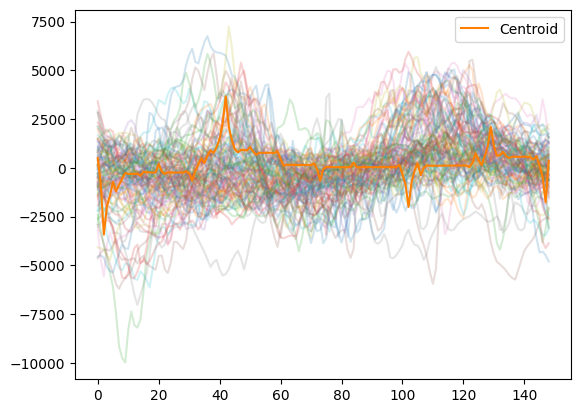

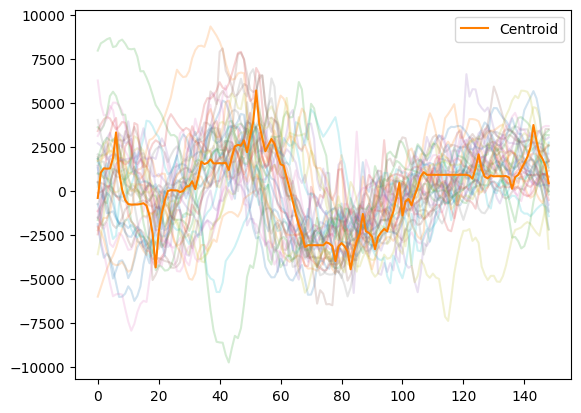

------------------------------------------------------------------------------------


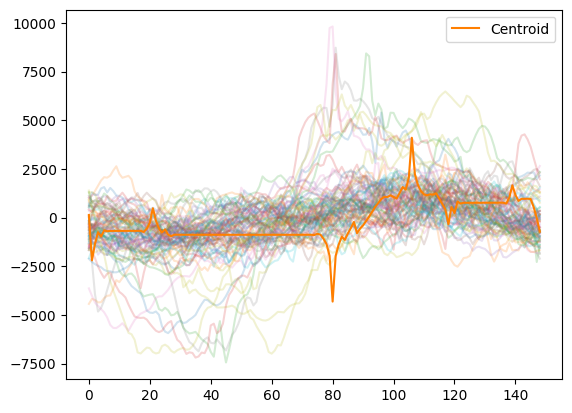

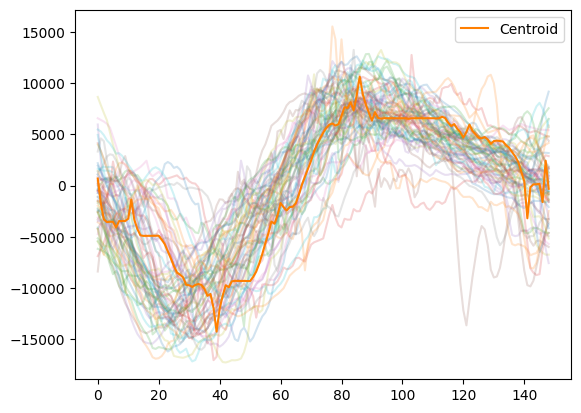

------------------------------------------------------------------------------------


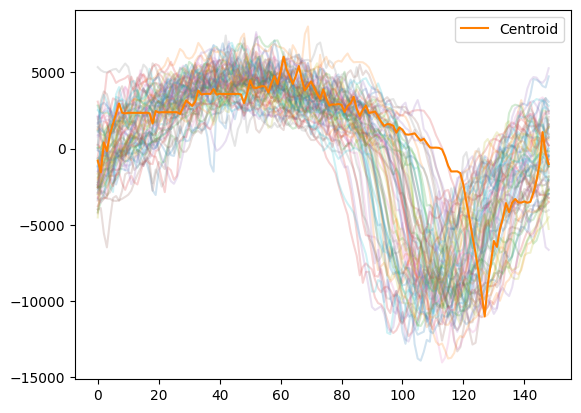

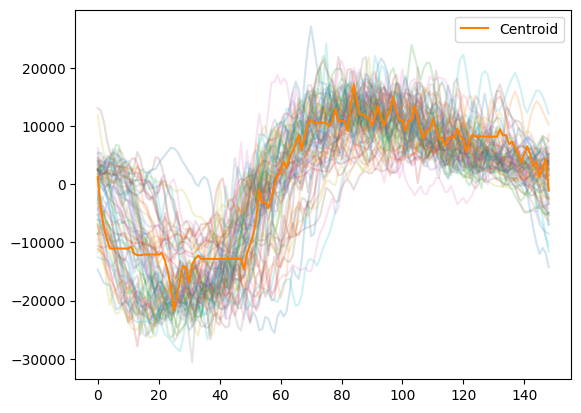

------------------------------------------------------------------------------------


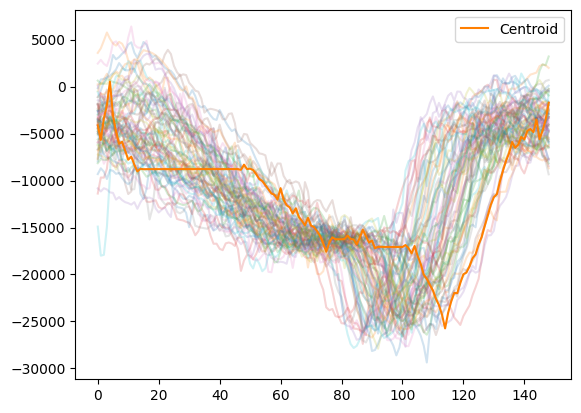

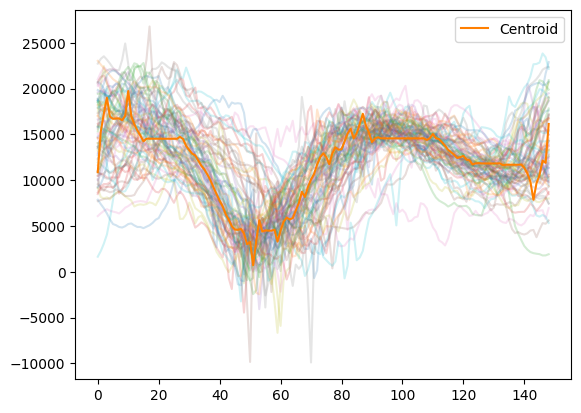

------------------------------------------------------------------------------------


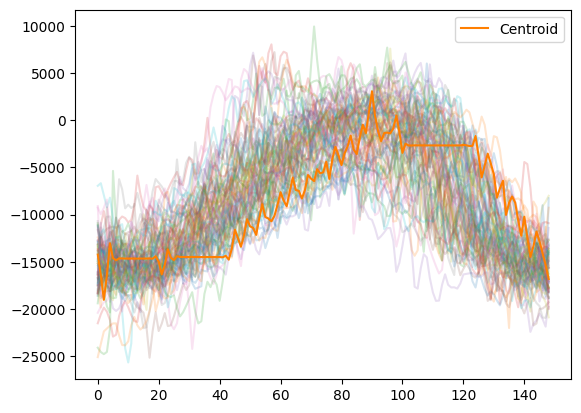

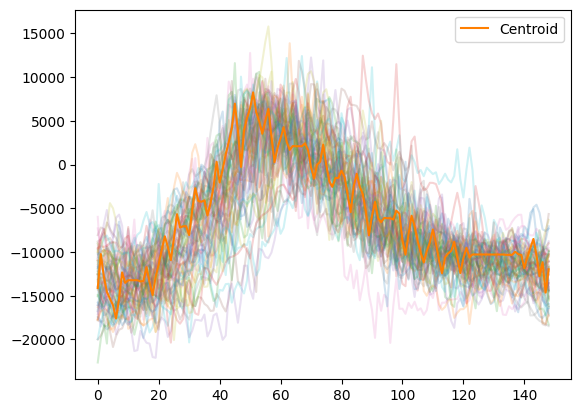

------------------------------------------------------------------------------------


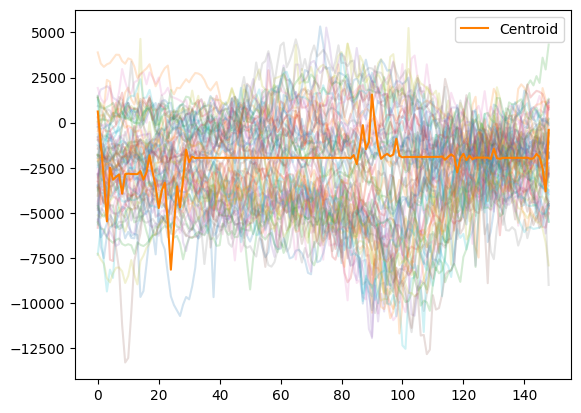

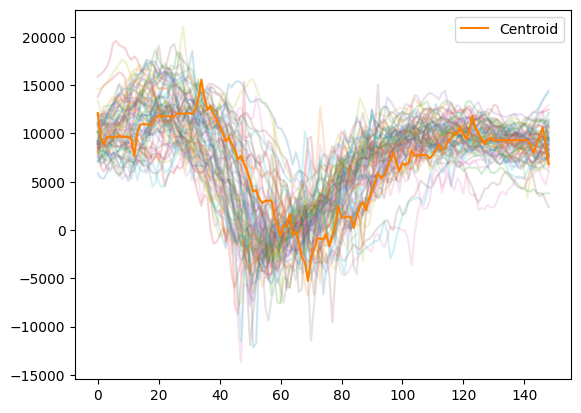

------------------------------------------------------------------------------------


In [5]:
from tslearn.clustering import TimeSeriesKMeans
colors = sns.color_palette("Paired")
nb_clusters = 2
answers = []

for i in range(6):
    stream = [streams[0][i] for streams in filtered_data]
    
    dba_km = TimeSeriesKMeans(n_clusters=nb_clusters ,
                            metric="dtw",
                            verbose=False,
                            random_state=0)
    y_pred = dba_km.fit_predict(stream)
    answers.append(y_pred)
    for cluster in range(nb_clusters):
        
        
        for xx in np.array(stream)[y_pred == cluster]:
            plt.plot(xx.ravel(), alpha=.2) 
        plt.plot(dba_km.cluster_centers_[cluster].ravel(), label = f"Centroid",alpha=1, color=colors[7], linestyle="-") 
        
        plt.legend() 
        plt.show()
    print("------------------------------------------------------------------------------------")

In [6]:
real_answers = np.array( [streams[1] for streams in filtered_data])


for answer in answers:
    
    score = np.sum(answer == real_answers) / len(real_answers)
    print(score)


"""
0.7412587412587412
0.972027972027972
1.0
1.0
0.965034965034965
1.0
"""

0.7692307692307693
0.9370629370629371
1.0
1.0
0.9230769230769231
1.0


'\n0.7412587412587412\n0.972027972027972\n1.0\n1.0\n0.965034965034965\n1.0\n'